### Load netCDF data

In [1]:
from netCDF4 import Dataset
import numpy as np

In [2]:
metadata = Dataset("../data/hrrrv4.geo_em.d01.nc", "r", format="NETCDF4")
print(metadata.data_model)

NETCDF3_64BIT_OFFSET


In [3]:
metadata.variables.keys()

dict_keys(['Times', 'XLAT_M', 'XLONG_M', 'XLAT_V', 'XLONG_V', 'XLAT_U', 'XLONG_U', 'CLAT', 'CLONG', 'MAPFAC_M', 'MAPFAC_V', 'MAPFAC_U', 'MAPFAC_MX', 'MAPFAC_VX', 'MAPFAC_UX', 'MAPFAC_MY', 'MAPFAC_VY', 'MAPFAC_UY', 'E', 'F', 'SINALPHA', 'COSALPHA', 'LANDMASK', 'XLAT_C', 'XLONG_C', 'SINALPHA_U', 'COSALPHA_U', 'SINALPHA_V', 'COSALPHA_V', 'LANDUSEF', 'LU_INDEX', 'HGT_M', 'SOILTEMP', 'SOILCTOP', 'SCT_DOM', 'SOILCBOT', 'SCB_DOM', 'ALBEDO12M', 'GREENFRAC', 'LAI12M', 'SNOALB', 'SLOPECAT', 'CON', 'VAR', 'OA1', 'OA2', 'OA3', 'OA4', 'OL1', 'OL2', 'OL3', 'OL4', 'VAR_SSO', 'LAKE_DEPTH', 'CONSS', 'OA1SS', 'OA2SS', 'OA3SS', 'OA4SS', 'OL1SS', 'OL2SS', 'OL3SS', 'OL4SS', 'VARSS'])

### Find lake points

In [4]:
land_use_points = np.squeeze(metadata.variables['LU_INDEX'][:].data)

In [5]:
land_use_points.shape

(1059, 1799)

In [6]:
lake_points = []
for i in range(len(land_use_points)):
    if len(np.where(land_use_points[i] == 21)[0]) != 0:
        col_idxs = np.where(land_use_points[i] == 21)[0]
        lake_points.extend( [ [i, col_idx] for col_idx in col_idxs ] )

lake_points[:5]

[[18, 887], [19, 887], [19, 888], [22, 832], [22, 833]]

In [7]:
landmask = np.squeeze(metadata.variables['LANDMASK'][:].data)

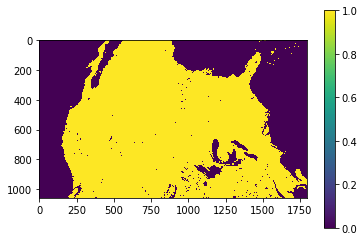

In [8]:
import matplotlib.pyplot as plt

plt.imshow(landmask, cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.show()

In [9]:
np.unique(landmask)

array([0., 1.], dtype=float32)

In [10]:
lats = np.squeeze(metadata.variables['CLAT'][:].data)
lons = np.squeeze(metadata.variables['CLONG'][:].data)
depths = np.squeeze(metadata.variables['LAKE_DEPTH'][:].data)

In [11]:
lake_lats = [ lats[tuple(point)] for point in lake_points ]
lake_lons = [ lons[tuple(point)] for point in lake_points ]
lake_depths = [ depths[tuple(point)] for point in lake_points ]

### 2020 06 20 T00 F00 Temps

In [12]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
import contextily as ctx

In [13]:
hrrr_output = Dataset("../data/hrrrX/sfc/20200620/hrrrX.t00z.wrfsfcf00.nc4", "r", format="NETCDF4")
print(hrrr_output.data_model)

NETCDF4


In [14]:
list(hrrr_output.variables.keys())

['y',
 'x',
 'latitude',
 'longitude',
 'time',
 'var0_16_196_entireatmosphere',
 'RETOP_cloudtop',
 'var0_16_201_entireatmosphere',
 'VIL_entireatmosphere',
 'VIS_surface',
 'var0_16_195_1000maboveground',
 'var0_16_195_4000maboveground',
 'var0_16_195_263Klevel',
 'GUST_surface',
 'DZDT_700mb',
 'var0_2_220_100M1000mbaboveground',
 'var0_2_221_100M1000mbaboveground',
 'DZDT_0D5M0D8sigmalayer',
 'var0_3_198_meansealevel',
 'var0_16_198_1000maboveground',
 'var0_7_199_5000M2000maboveground',
 'var0_7_199_6000M1000maboveground',
 'var0_7_200_5000M2000maboveground',
 'var0_7_200_6000M1000maboveground',
 'var0_7_199_2000M0maboveground',
 'var0_7_200_2000M0maboveground',
 'var0_7_199_3000M0maboveground',
 'var0_7_200_3000M0maboveground',
 'RELV_2000M0maboveground',
 'RELV_1000M0maboveground',
 'HAIL_entireatmosphere',
 'HAIL_0D1sigmalevel',
 'HAIL_surface',
 'TCOLG_localleveltype2000',
 'LTPINX_1maboveground',
 'LTPINX_2maboveground',
 'var0_17_192_entireatmosphere',
 'var0_7_197_5000M2000

In [15]:
lake_temps = np.squeeze(hrrr_output.variables['TMP_surface'][:].data)
air_temps = np.squeeze(hrrr_output.variables['TMP_2maboveground'][:].data)

lake_temps = np.array([ lake_temps[tuple(point)] for point in lake_points ])
air_temps = np.array([ air_temps[tuple(point)] for point in lake_points ])

lake_temps = lake_temps - 273
air_temps = air_temps - 273

lake_temps[:5]

array([25.010101, 25.947601, 28.697601, 29.947601, 30.010101],
      dtype=float32)

In [16]:
# load lake points as geodataframe
df = pd.DataFrame(data={'idx': lake_points, 'water_temp': lake_temps, 'air_temp': air_temps })

geometry = [ Point(xy) for xy in zip(lake_lons, lake_lats) ]
gdf = gpd.GeoDataFrame(df, crs='epsg:4326', geometry=geometry)
gdf = gdf.to_crs(epsg=3857)
gdf.head()

,idx,water_temp,air_temp,geometry
0,"[18, 887]",25.010101,28.79184,POINT (-10892310.503 2855647.834)
1,"[19, 887]",25.947601,28.85434,POINT (-10892320.694 2858870.329)
2,"[19, 888]",28.697601,29.72934,POINT (-10889096.750 2858882.497)
3,"[22, 832]",29.947601,29.47934,POINT (-11069732.736 2866337.204)
4,"[22, 833]",30.010101,29.60434,POINT (-11066508.792 2866403.697)


### Plot points

In [17]:
from pyproj import Transformer

def get_state_bounds(abbr):
    # get bounds for state and convert to epsg:3857
    usa = gpd.read_file('../data/states_21basic/states.shp')

    state_bounds = usa[usa.STATE_ABBR == abbr].total_bounds.reshape((2, 2))

    transformer = Transformer.from_crs("epsg:4326", "epsg:3857")

    state_bounds[0] = transformer.transform(state_bounds[0,1]-0.1, state_bounds[0,0]-0.1)
    state_bounds[1] = transformer.transform(state_bounds[1,1]+0.1, state_bounds[1,0]+0.1)
    
    return state_bounds

In [18]:
usa_states = gpd.read_file('../data/states_21basic/states.shp')

In [19]:
usa_states

,STATE_NAME,DRAWSEQ,STATE_FIPS,SUB_REGION,STATE_ABBR,geometry
0,Hawaii,1,15,Pacific,HI,"MULTIPOLYGON (((-160.07380 22.00418, -160.0497..."
1,Washington,2,53,Pacific,WA,"MULTIPOLYGON (((-122.40202 48.22522, -122.4628..."
2,Montana,3,30,Mountain,MT,"POLYGON ((-111.47543 44.70216, -111.48080 44.6..."
3,Maine,4,23,New England,ME,"MULTIPOLYGON (((-69.77728 44.07415, -69.85993 ..."
4,North Dakota,5,38,West North Central,ND,"POLYGON ((-98.73044 45.93827, -99.00683 45.939..."
5,South Dakota,6,46,West North Central,SD,"POLYGON ((-102.78838 42.99530, -103.00588 42.9..."
6,Wyoming,7,56,Mountain,WY,"POLYGON ((-104.05362 41.69822, -104.05550 41.5..."
7,Wisconsin,8,55,East North Central,WI,"MULTIPOLYGON (((-87.74856 44.96162, -87.83999 ..."
8,Idaho,9,16,Mountain,ID,"POLYGON ((-117.02630 43.67903, -117.02379 43.7..."
9,Vermont,10,50,New England,VT,"POLYGON ((-73.25806 42.74606, -73.26928 42.747..."


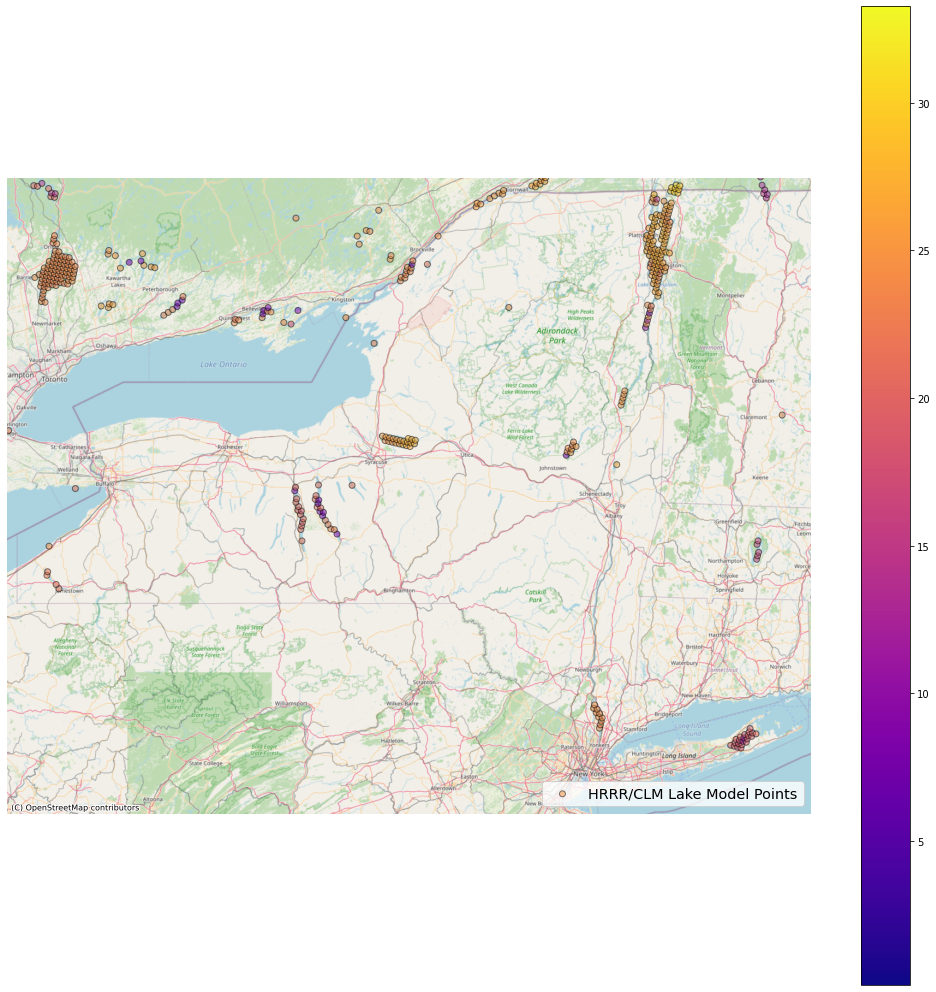

In [20]:
ax = gdf.plot(
    figsize=(18, 18), 
    alpha=0.5, 
    edgecolor='k', 
    label='HRRR/CLM Lake Model Points',
    column='water_temp', 
    cmap=plt.get_cmap('plasma'), 
    legend=True
)

# set bounds
state_bounds = get_state_bounds('NY')
ax.set_xlim(state_bounds[:, 0])
ax.set_ylim(state_bounds[:, 1])

plt.legend(loc="lower right", fontsize='x-large')

ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, zoom=8)
ax.set_axis_off()

# plt.savefig('./figures/temp-explore/', bbox_inches='tight')

### Interactive Map

In [21]:
import json

from bokeh.io import output_file, output_notebook, show
from bokeh.models import (
  GMapPlot, GMapOptions, ColumnDataSource, Circle, LogColorMapper, BasicTicker, ColorBar,
    DataRange1d, Range1d, PanTool, WheelZoomTool, BoxSelectTool, ResetTool, HoverTool
)
from bokeh.models.mappers import ColorMapper, LinearColorMapper
from bokeh.palettes import Viridis256
from bokeh.plotting import figure
from bokeh.resources import CDN
from bokeh.embed import file_html

In [23]:
with open('../keys.json', 'r') as f:
    keys = json.loads(f.read())

In [24]:
map_options = GMapOptions(lat=42.6681422, lng=-73.8457002, map_type="roadmap", zoom=6)

plot = GMapPlot(
    x_range=Range1d(), y_range=Range1d(), map_options=map_options
)
plot.title.text = "Lake Points with Temp Gradient"

plot.api_key = keys['google_maps_api_key']
source = ColumnDataSource(
    data=dict(
        lat=lake_lats,
        lon=lake_lons,
        size=[10]*len(lake_lons),
        water_temp=lake_temps,
        air_temp=air_temps,
        depth=lake_depths
    )
)

color_mapper = LinearColorMapper(palette=Viridis256)

circle = Circle(
    x="lon", 
    y="lat", 
    size="size", 
    fill_color={'field': 'depth', 'transform': color_mapper}, 
    fill_alpha=1, 
    line_color='black'
)
plot.add_glyph(source, circle)

color_bar = ColorBar(
    color_mapper=color_mapper, 
    ticker=BasicTicker(), 
    label_standoff=12, 
    border_line_color=None, 
    location=(0,0)
)
plot.add_layout(color_bar, 'right')


plot.add_tools(PanTool(), WheelZoomTool(), BoxSelectTool(), ResetTool(), HoverTool(tooltips=[('water', '@water_temp'), ('depth', '@depth')]))

output_notebook()
show(plot)

Loading BokehJS ...

### Close file

In [ ]:
metadata.close()
hrrr_output.close()